In [1]:
import random
import keras
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, recall_score, f1_score, confusion_matrix
from keras.models import Input, Model, load_model
from keras.layers import LSTM, Dense
from keras.optimizers import Nadam

import os

from laughter_classification.sspnet_data_sampler import SSPNetDataSampler

C:\Users\IMBD\AppData\Roaming\Python\Python36\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
CLEAN = 0
NOISY = 1
IF_NOISY = False

ALL_FEATURES = 148
MFCC_FEATURES = 20
FBANK_FEATURES = 128
FRAMES = 22

BATCH_SIZE = 32
N_EPOCHS = 50
FRAME_LENGTH = 0.5

data_path = ["vocalizationcorpus", "vocalizationcorpus_noisy"]
csv_file = ["new_out.csv", "new_out_noisy.csv"]
model_name = ["model.h5", "model_noisy.h5"]

In [3]:
# Create csv file if necessary

#sampler = SSPNetDataSampler(data_path[NOISY])
#sampler.create_sampled_df(FRAME_LENGTH, save_path=csv_file[NOISY], force_save=True)

In [4]:
data_list = [pd.read_csv(csv_file[CLEAN]), pd.read_csv(csv_file[NOISY])]

In [5]:
def create_data_for_train(data):

    index = data['SNAME'].unique()
    train_index, test_index = train_test_split(index, shuffle=False)

    train_data = np.array(data[data['SNAME'].isin(train_index)].drop(columns='SNAME'))
    test_data = np.array(data[data['SNAME'].isin(test_index)].drop(columns='SNAME'))

    X_train = train_data[:, :-1].reshape(len(train_index), FRAMES, ALL_FEATURES)
    X_test = test_data[:, :-1].reshape(len(test_index), FRAMES, ALL_FEATURES)

    y_train = keras.utils.to_categorical(train_data[:, -1], 2).reshape(len(train_index), FRAMES, 2)
    y_test = keras.utils.to_categorical(test_data[:, -1], 2).reshape(len(test_index), FRAMES, 2)

    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = create_data_for_train(data_list[IF_NOISY])
_, X_test_another, _, _ = create_data_for_train(data_list[not IF_NOISY])

mfcc_inp = Input(shape=(X_train.shape[1], MFCC_FEATURES))
fbank_inp = Input(shape=(X_train.shape[1], FBANK_FEATURES))
lstm_mfcc = LSTM(128, return_sequences=True)(mfcc_inp)
lstm_fbank = LSTM(64, return_sequences=True)(fbank_inp)
mfcc_output = Dense(2, activation='softmax')(lstm_mfcc)
lstm_concat = keras.layers.concatenate([lstm_mfcc, lstm_fbank], axis=2)
out = Dense(2, activation='softmax')(lstm_concat)
model = Model(inputs=[mfcc_inp, fbank_inp], outputs=[mfcc_output, out])

In [7]:
# model = load_model(model_name[IF_NOISY])

model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=0.001), metrics=['accuracy'])
model.fit([X_train[:, :, :MFCC_FEATURES], X_train[:, :, MFCC_FEATURES:]], [y_train, y_train], validation_split=0.2,
          batch_size=BATCH_SIZE, epochs=N_EPOCHS)

model.save(model_name[IF_NOISY])

Train on 600 samples, validate on 150 samples
Epoch 1/50
600/600 [==============================] - 3s 5ms/step - loss: 0.6040 - dense_1_loss: 0.3400 - dense_2_loss: 0.2640 - dense_1_acc: 0.8567 - dense_2_acc: 0.9486 - val_loss: 0.2288 - val_dense_1_loss: 0.1119 - val_dense_2_loss: 0.1169 - val_dense_1_acc: 0.9776 - val_dense_2_acc: 0.9773
Epoch 2/50
600/600 [==============================] - 1s 2ms/step - loss: 0.3126 - dense_1_loss: 0.1546 - dense_2_loss: 0.1580 - dense_1_acc: 0.9592 - dense_2_acc: 0.9593 - val_loss: 0.2022 - val_dense_1_loss: 0.1012 - val_dense_2_loss: 0.1010 - val_dense_1_acc: 0.9770 - val_dense_2_acc: 0.9767
Epoch 3/50
600/600 [==============================] - 1s 2ms/step - loss: 0.2724 - dense_1_loss: 0.1364 - dense_2_loss: 0.1361 - dense_1_acc: 0.9598 - dense_2_acc: 0.9599 - val_loss: 0.2032 - val_dense_1_loss: 0.1075 - val_dense_2_loss: 0.0957 - val_dense_1_acc: 0.9776 - val_dense_2_acc: 0.9773
Epoch 4/50
600/600 [==============================] - 1s 2ms/step 

In [8]:
y_pred = model.predict([X_test[:, :, :MFCC_FEATURES], X_test[:, :, MFCC_FEATURES:]])[1]
y_pred_res = np.apply_along_axis(lambda x: int(x[1] >= x[0]), 2, y_pred)
y_test_res = np.apply_along_axis(lambda x: int(x[1] == 1.0), 2, y_test)

In [12]:
def check_results(y_t, y_pr, y_pr_raw):
    pred_list = []
    real_list = []
    for i in range(y_t.shape[0]):
        for j in range(y_t.shape[1]):
            pred_list.append(y_pr[i, j])
            real_list.append(y_t[i, j])

    print('Accuracy:', accuracy_score(real_list, pred_list))
    print('Recall:', recall_score(real_list, pred_list))
    print('F1:', f1_score(real_list, pred_list))
    print('Confusion matrix:\n', confusion_matrix(real_list, pred_list))
    fp, tp, _ = roc_curve(real_list, pred_list)
    print('Area:', auc(fp, tp))

    plt.figure(figsize=(8, 8))
    plt.plot(fp, tp)
    plt.show()
    
    num = 0
    SHOW_NUM = 3
    for i in range(y_test.shape[0]):
        if np.max(y_test[i, :, 1]) == 1:
            num += 1
            plt.plot(np.arange(0, FRAMES), y_test[i, :, 1])
            plt.plot(np.arange(0, FRAMES), y_pr_raw[i, :, 1])
            plt.legend(['real laughter', 'predicted laughter'])
            plt.show()
            if num >= SHOW_NUM:
                break

Accuracy: 0.980909090909091
Recall: 0.29906542056074764
F1: 0.37869822485207094
Confusion matrix:
 [[5363   30]
 [  75   32]]
Area: 0.6467513270057585


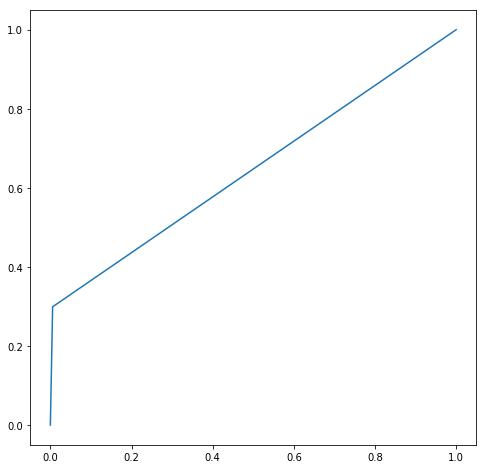

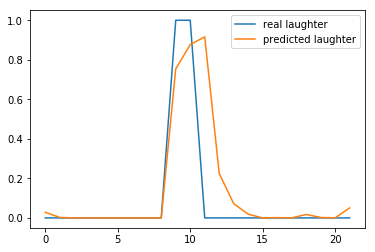

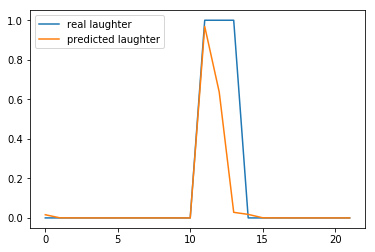

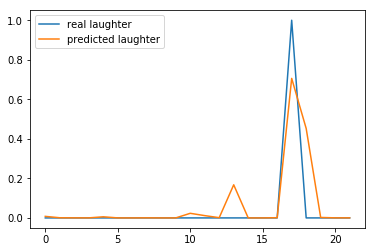

In [13]:
check_results(y_test_res, y_pred_res, y_pred)

Check on noisy if clean and vice versa
Accuracy: 0.980909090909091
Recall: 0.037383177570093455
F1: 0.07079646017699114
Confusion matrix:
 [[5391    2]
 [ 103    4]]
Area: 0.5185061632334057


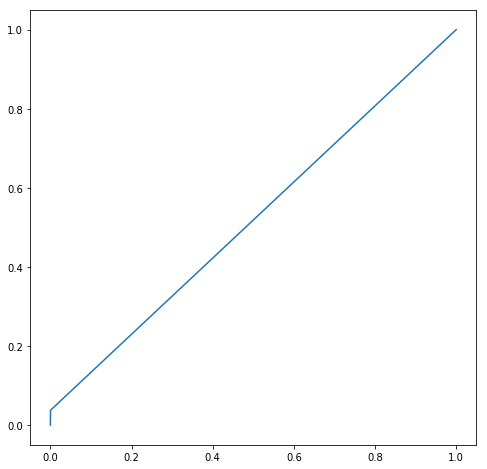

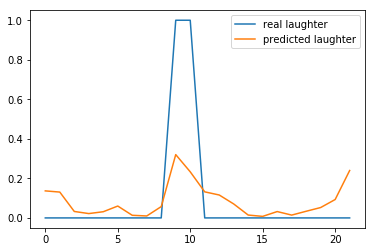

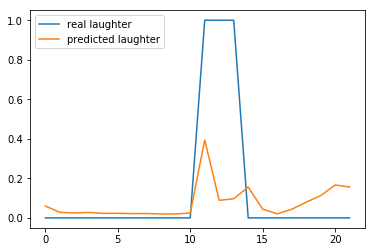

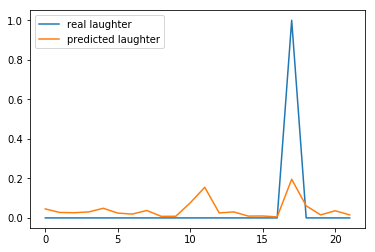

In [14]:
print('Check on noisy if clean and vice versa')
y_pred_another = model.predict([X_test_another[:, :, :MFCC_FEATURES], X_test_another[:, :, MFCC_FEATURES:]])[1]
y_pred_another_res = np.apply_along_axis(lambda x: int(x[1] >= x[0]), 2, y_pred_another)
check_results(y_test_res, y_pred_another_res, y_pred_another)